## Testings of SARIMA models on hourly energy consumption in the US
East Kentucky Power Cooperative (EKPC) \
estimated energy consumption in Megawatts (MW)
data is provided on a hourly basis for the time period: 2013-06-01 to 2018-08-03

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import warnings
import matplotlib.pyplot as plt
# warnings.filterwarnings("ignore")

### 1.) Load the data

In [2]:
# Load the data
data = pd.read_csv('../data/EKPC_hourly.csv', index_col='Datetime', parse_dates=True)
data.head(5)

,EKPC_MW
Datetime,
2013-12-31 01:00:00,1861.0
2013-12-31 02:00:00,1835.0
2013-12-31 03:00:00,1841.0
2013-12-31 04:00:00,1872.0
2013-12-31 05:00:00,1934.0


In [3]:
data = data.sort_index()
train = data.loc[data.index <= '2016-12-31']
test = data.loc[data.index > '2016-12-31']
data.describe()	

,EKPC_MW
count,45334.000000
mean,1464.218423
std,378.868404
min,514.000000
25%,1185.000000
50%,1386.000000
75%,1699.000000
max,3490.000000


### 2.) Plotting the data
Discover potential yoy trend and eventual heteroskedastic behaviour in the variance

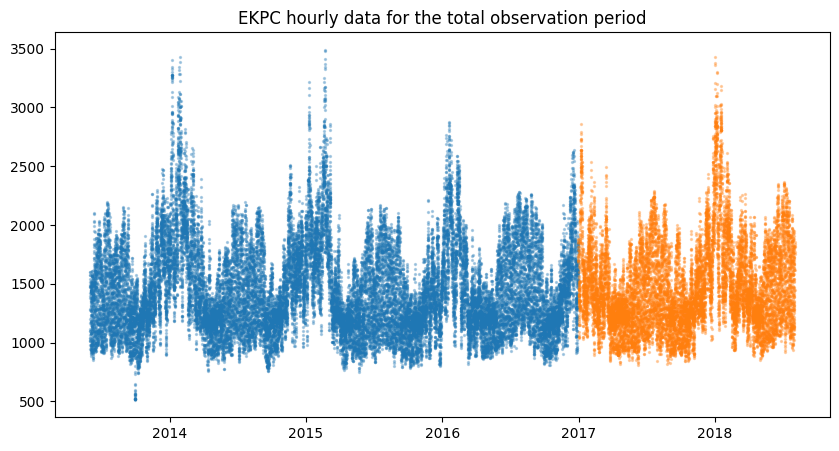

In [4]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(
        train.index,
        train,
        s=2,  # Size of dots
        alpha=0.3,  # Transparency of dots
    )
plt.scatter(
        test.index,
        test,
        s=2,  # Size of dots
        alpha=0.3,  # Transparency of dots
    )
plt.title('EKPC hourly data for the total observation period')
plt.show()

#### 2.1.) Check data for one year

In [18]:
start_date = pd.Timestamp('2014-01-01T01')
end_date = start_date + pd.Timedelta(days=364,hours=23)
print(start_date,";", end_date)

2014-01-01 01:00:00 ; 2015-01-01 00:00:00


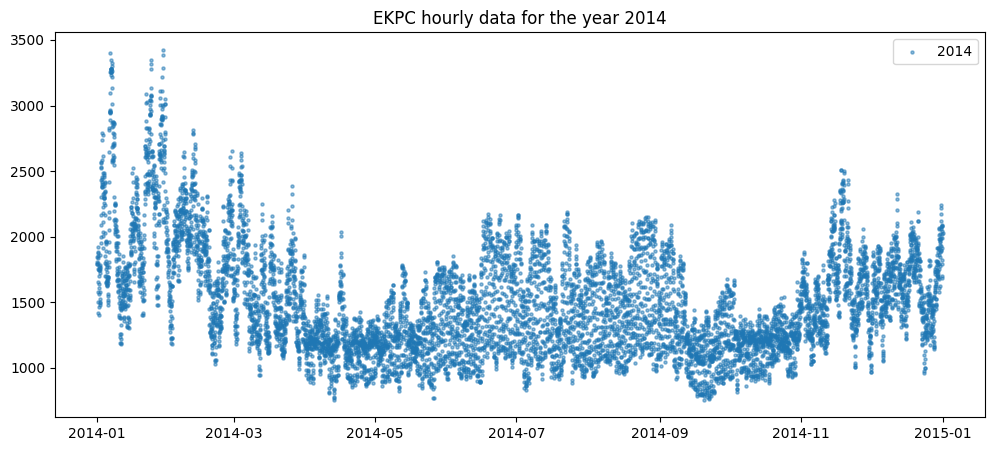

In [20]:
plt.figure(figsize=(12, 5))
# Normalize the data for the week
year_data = data.loc[start_date:end_date]
# Create a label for the year
label = f"{start_date.year}"
plt.scatter(
    year_data.index,
    year_data,
    s=5,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label = label
)
# Set x-axis ticks to days of the week
# days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# ax.set_xticks(pd.date_range(start=random_mondays[0], periods=7, freq='D'))
# ax.set_xticklabels(days_of_week)
plt.title('EKPC hourly data for the year 2014')
plt.legend()
plt.show()

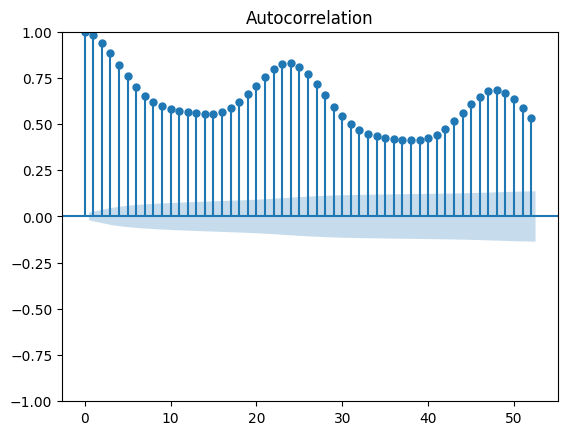

In [23]:
acf_original = plot_acf(year_data, lags=52) # number of lags corresponds to number of datapoints in a week-1

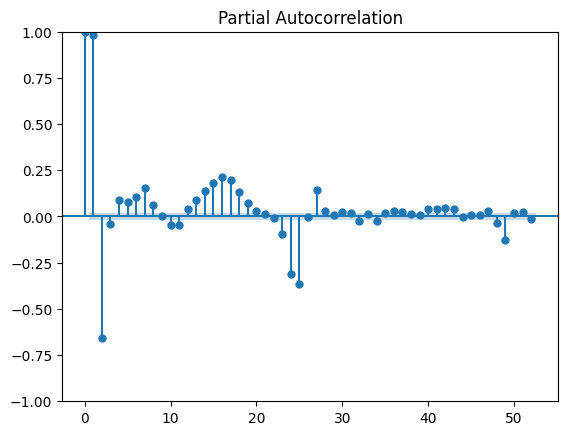

In [24]:
pacf_original = plot_pacf(year_data, lags=52) # number of lags corresponds to number of datapoints in a week-1

#### 2.1.) Investigate weekly data
Data is normalized to account to perticularities present at various weeks

C:\Users\david\AppData\Local\Temp\ipykernel_11052\3140055514.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_timestamps = pd.date_range(start=random_mondays[0], periods=7*24, freq='H')


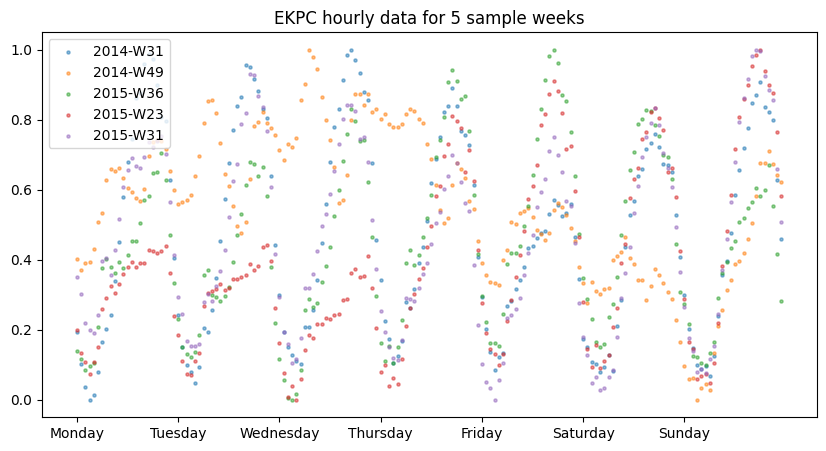

In [5]:
start_date = data.index.min()
end_date = data.index.max()
date_range = pd.date_range(start=start_date, end=end_date)

# Filter for Mondays
mondays = date_range[date_range.weekday == 0]

# Select 5 random weeks from Monday to Friday
random_mondays = np.random.choice(mondays, 5, replace=False)
random_sundays = random_mondays + pd.Timedelta(days=6, hours=23)
hourly_timestamps = pd.date_range(start=random_mondays[0], periods=7*24, freq='H')

# Plot the data for the 5 sample weeks
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(5):

    # Normalize the data for the week
    sample_week_data = data.loc[random_mondays[i]:random_sundays[i]]
    min_val = sample_week_data.min()
    max_val = sample_week_data.max()
    normalized_data = (sample_week_data - min_val) / (max_val - min_val)
    # Get the year and week number
    year_week = random_mondays[i].astype('datetime64[M]').astype('O').isocalendar()
    # Create a label for the week
    label = f"{year_week.year}-W{year_week.week:02d}"
    plt.scatter(
        hourly_timestamps,
        normalized_data,
        s=5,  # Size of dots
        alpha=0.5,  # Transparency of dots
        label = label
    )
# Set x-axis ticks to days of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_xticks(pd.date_range(start=random_mondays[0], periods=7, freq='D'))
ax.set_xticklabels(days_of_week)
plt.title('EKPC hourly data for 5 sample weeks')
plt.legend()
plt.show()

Variety on weekly basis, so for short term forecasting only the past 2 weeks will be used.

### 3.) Identifying the dependence orders of the model

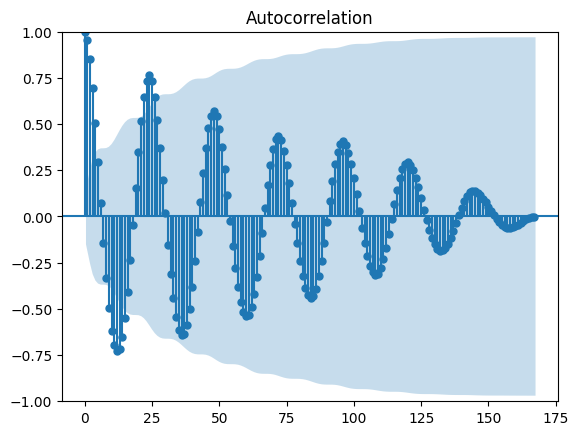

In [6]:
acf_original = plot_acf(sample_week_data, lags=24*7-1) # number of lags corresponds to number of datapoints in a week-1

ACF indicates 24 hour pattern

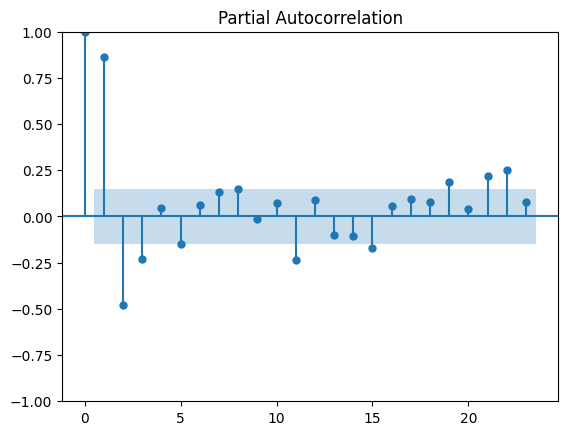

In [113]:
pacf_original = plot_pacf(sample_week_data)

In [ ]:

# Fit the ARIMA model
model = ARIMA(data, order=(5, 1, 0))
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

# Plot the residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
plt.show()
residuals.plot(kind='kde', title='Density')
plt.show()

# Print residuals description
print(residuals.describe())